In [1]:
from roofline_utils import *
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder

Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534
SP Balance Point is at: 32.97 flop/byte
DP Balance Point is at: 0.52 flop/byte
INT Balance Point is at: 16.49 intop/byte

These values get passed as LLM context so the model can infer about rooflines:
Peak SP GFLOP/s 25067.52 with FMA
Peak DP GFLOP/s 391.68 with FMA
Peak GINTOP/s 12533.76 with FMA


## Open the CSV file

In [2]:

resultsCSV = 'zero-shot-inference-results.csv'

dtypes['language'] = 'string'
dtypes['numTokens'] = np.int64
dtypes['kernelCode'] = 'string'
dtypes['isBB'] = np.int64
dtypes['class'] = 'string'
dtypes['answer'] = 'string'
dtypes['topp'] = np.float64
dtypes['temp'] = np.float64
dtypes['llmResponse'] = 'string'
dtypes['trial'] = np.int64
dtypes['isTrain'] = np.int64

df = pd.read_csv(resultsCSV, quotechar='\"', dtype=dtypes)

In [3]:
print(df.shape)
print(df.columns)

df.drop(['kernelCode'], axis=1, inplace=True)

print(df.shape)
print(df.columns)

(9450, 27)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer', 'isTrain', 'trial', 'topp',
       'temp', 'llmResponse'],
      dtype='object')
(9450, 26)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens', 'isBB',
       'class', 'answer', 'isTrain', 'trial', 'topp', 'temp', 'llmResponse'],
      dtype='object')


In [4]:
df['isLLMCorrect'] = df.apply(lambda x: x['answer'] == x['llmResponse'], axis=1)

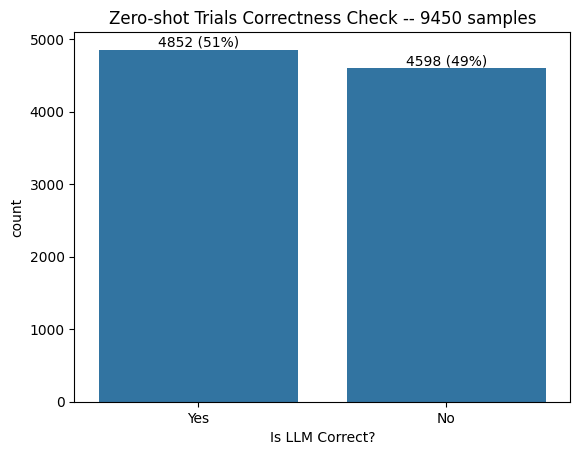

In [5]:
ax = sns.countplot(data=df, order=df['isLLMCorrect'].value_counts(ascending=False).index, x='isLLMCorrect')

abs_values = df['isLLMCorrect'].value_counts(ascending=False)
rel_values = df['isLLMCorrect'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_xlabel('Is LLM Correct?')
ax.set_title(f'Zero-shot Trials Correctness Check -- {df.shape[0]} samples')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()

    temp  topp  isLLMCorrect  count    tempTopp
0    0.1   0.2         False    513  (0.1, 0.2)
1    0.1   0.2          True    537  (0.1, 0.2)
2    0.1   0.5         False    509  (0.1, 0.5)
3    0.1   0.5          True    541  (0.1, 0.5)
4    0.1   0.9         False    502  (0.1, 0.9)
5    0.1   0.9          True    548  (0.1, 0.9)
6    0.2   0.2         False    509  (0.2, 0.2)
7    0.2   0.2          True    541  (0.2, 0.2)
8    0.2   0.5         False    519  (0.2, 0.5)
9    0.2   0.5          True    531  (0.2, 0.5)
10   0.2   0.9         False    506  (0.2, 0.9)
11   0.2   0.9          True    544  (0.2, 0.9)
12   0.5   0.2         False    515  (0.5, 0.2)
13   0.5   0.2          True    535  (0.5, 0.2)
14   0.5   0.5         False    521  (0.5, 0.5)
15   0.5   0.5          True    529  (0.5, 0.5)
16   0.5   0.9         False    504  (0.5, 0.9)
17   0.5   0.9          True    546  (0.5, 0.9)


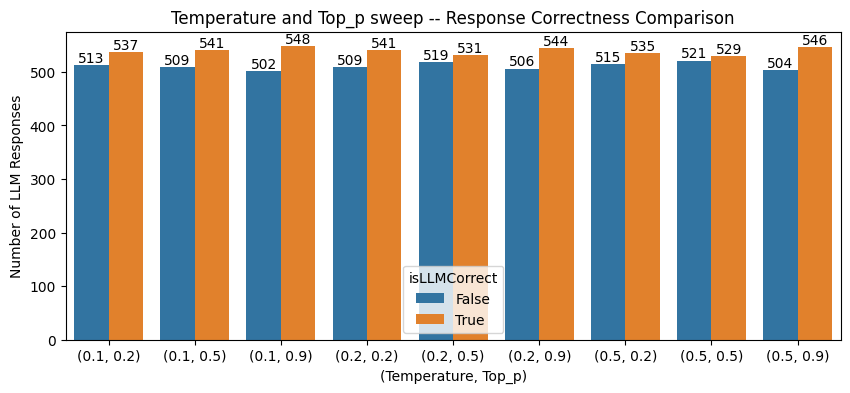

In [15]:
# visualize by levels
grouped = df.groupby(['temp', 'topp', 'isLLMCorrect'])['isLLMCorrect'].value_counts().reset_index()


grouped['tempTopp'] = list(zip(grouped['temp'], grouped['topp']))
grouped['tempTopp'] = grouped['tempTopp'].apply(str)

print(grouped)

fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.barplot(data=grouped, x='tempTopp', y='count', hue='isLLMCorrect', ax = ax)

ax.set_xlabel('(Temperature, Top_p)')
ax.set_ylabel('Number of LLM Responses')
ax.set_title('Temperature and Top_p sweep -- Response Correctness Comparison')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()



[[2223 2502]
 [2096 2629]]


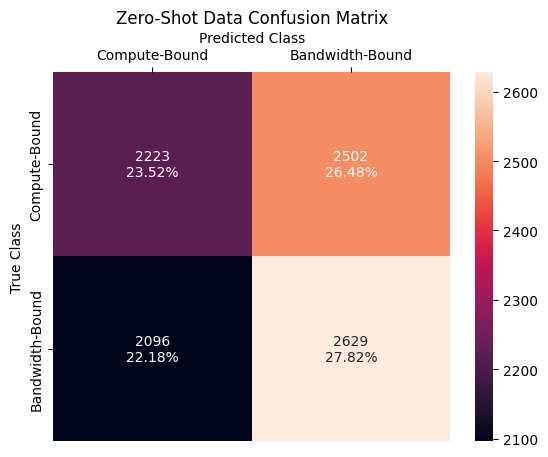

In [16]:

cf_matrix = confusion_matrix(df['answer'], df['llmResponse'], labels=['Compute', 'Bandwidth'])
print(cf_matrix)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
ax = sns.heatmap(cf_matrix, annot=labels, fmt='')

ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title('Zero-Shot Data Confusion Matrix')

ax.set_xticklabels(['Compute-Bound', 'Bandwidth-Bound'])
ax.set_yticklabels(['Compute-Bound', 'Bandwidth-Bound'])
plt.show()

In [8]:

class_report = classification_report(df['answer'], df['llmResponse'], labels=['Compute', 'Bandwidth'], target_names=['Compute-Bound', 'Bandwidth-Bound'])
print(class_report)

# precision: Percentage of correct predictions relative to total predictions

                 precision    recall  f1-score   support

  Compute-Bound       0.51      0.47      0.49      4725
Bandwidth-Bound       0.51      0.56      0.53      4725

       accuracy                           0.51      9450
      macro avg       0.51      0.51      0.51      9450
   weighted avg       0.51      0.51      0.51      9450



## Chi-Squared Test

We want to know: are the hyperparameters of the model statistically significant in affecting the outcomes of the predictions?

If no: we'll use small temperature and top_p in future LLM uses

If yes: we'll use the best of the sampled temperature and top_p values for future LLM inference

---------------

Null hypothesis (H₀): The two categorical hyperparameters have no effect on the binary predictions of the model.

Alternative hypothesis (H₁): The two categorical hyperparameters do have an effect on the binary predictions of the model.

In [9]:
# Let's start with a contingency table

# The desired columns are:
# Row 1 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 2 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 3 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# etc.

# Row 1 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 2 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 3 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# etc.

grouped = df.groupby(['temp', 'topp', 'isLLMCorrect'])['isLLMCorrect'].value_counts().reset_index()
grouped['tempTopp'] = list(zip(grouped['temp'], grouped['topp']))
grouped['tempTopp'] = grouped['tempTopp'].apply(str)
grouped.drop(['temp', 'topp'], inplace=True, axis=1)
#print(grouped)
#print()

contTable = grouped.pivot(index='tempTopp', columns='isLLMCorrect', values='count').reset_index().reset_index(drop=True)
#contTable.drop(['isLLMCorrect'], inplace=True, axis=1)
contTable = contTable.rename_axis(None, axis=1)

contTable = contTable.rename(columns={False:'LLMisWRONG', True:'LLMisRIGHT'})
print(contTable)
print(contTable.columns)


contingency_table = contTable[['LLMisWRONG', 'LLMisRIGHT']].to_numpy()
print(contingency_table)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

# Interpretation:
if p_value < 0.05:
    print("Reject the null hypothesis: The hyperparameters significantly affect the predictions.")
else:
    print("Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.")





     tempTopp  LLMisWRONG  LLMisRIGHT
0  (0.1, 0.2)         513         537
1  (0.1, 0.5)         509         541
2  (0.1, 0.9)         502         548
3  (0.2, 0.2)         509         541
4  (0.2, 0.5)         519         531
5  (0.2, 0.9)         506         544
6  (0.5, 0.2)         515         535
7  (0.5, 0.5)         521         529
8  (0.5, 0.9)         504         546
Index(['tempTopp', 'LLMisWRONG', 'LLMisRIGHT'], dtype='object')
[[513 537]
 [509 541]
 [502 548]
 [509 541]
 [519 531]
 [506 544]
 [515 535]
 [521 529]
 [504 546]]
Chi-Square Statistic: 1.322436867242541
P-value: 0.9952786441778259
Degrees of Freedom: 8
Expected Frequencies: 
[[510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]
 [510.88888889 539.11111111]]
Fail to reject the null hypothesis: The hyperparameters do not significantly affe

In [10]:
# Let's start with a contingency table

# The desired columns are:
# Row 1 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 2 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 3 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# etc.

# Row 1 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 2 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 3 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# etc.

grouped = df.groupby(['temp', 'topp', 'llmResponse'])['llmResponse'].value_counts().reset_index()
grouped['tempTopp'] = list(zip(grouped['temp'], grouped['topp']))
grouped['tempTopp'] = grouped['tempTopp'].apply(str)
grouped.drop(['temp', 'topp'], inplace=True, axis=1)
#print(grouped)
#print()

contTable = grouped.pivot(index='tempTopp', columns='llmResponse', values='count').reset_index().reset_index(drop=True)
contTable = contTable.rename_axis(None, axis=1)

print(contTable)
print(contTable.columns)


contingency_table = contTable[['Bandwidth', 'Compute']].to_numpy()
print(contingency_table)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

# Interpretation:
if p_value < 0.05:
    print("Reject the null hypothesis: The hyperparameters significantly affect the predictions.")
else:
    print("Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.")


# Should we do Bonferroni correction for this test?


     tempTopp  Bandwidth  Compute
0  (0.1, 0.2)        554      496
1  (0.1, 0.5)        580      470
2  (0.1, 0.9)        579      471
3  (0.2, 0.2)        556      494
4  (0.2, 0.5)        578      472
5  (0.2, 0.9)        577      473
6  (0.5, 0.2)        564      486
7  (0.5, 0.5)        572      478
8  (0.5, 0.9)        571      479
Index(['tempTopp', 'Bandwidth', 'Compute'], dtype='string')
[[554 496]
 [580 470]
 [579 471]
 [556 494]
 [578 472]
 [577 473]
 [564 486]
 [572 478]
 [571 479]]
Chi-Square Statistic: 3.0199691897251495
P-value: 0.9330981227689505
Degrees of Freedom: 8
Expected Frequencies: 
[[570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]
 [570.11111111 479.88888889]]
Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.


## Area Under Curve + ROC Curve

ROC AUC Score: 0.5134391534391535


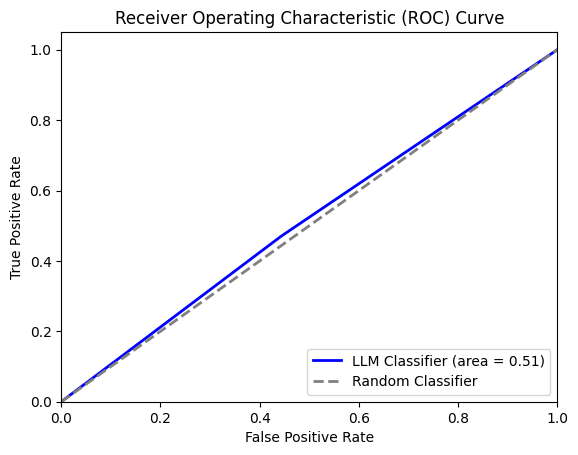

In [12]:
# Encode the categorical string labels to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['answer'])
predicted_labels_encoded = label_encoder.transform(df['llmResponse'])

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels_encoded, predicted_labels_encoded)
print(f"ROC AUC Score: {roc_auc}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels_encoded, predicted_labels_encoded)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LLM Classifier (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()